# Meat Elasticity Modelling

## Auth and package setup

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Authenticated
Mounted at /content/drive


In [2]:
from google.cloud import bigquery
import pandas_gbq
import pandas as pd
import numpy as np
import sys
import os
import plotnine as p9
from mizani.formatters import currency_format

In [3]:
%load_ext google.colab.data_table

## Get data

In [4]:
# def bq_sql_mainData(lagDays=7):
#     query = """
#     #standardSQL
#     create temp table elastData_meat as (
#     with asp_dat as
#     (
#     SELECT
#     ifnull(SalesOrg,'') as SalesOrg,
#     ifnull(Site,'') as Site,
#     ifnull(Article,'') as Article,
#     ifnull(Article_Description,'') as Article_Description,
#     ifnull(Category_Description,'') as Category_Description,
#     ifnull(SubCategory_Description,'') as SubCategory_Description,
#     ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),'') as Sales_Unit, Calendar_Day
#     , DATE_ADD(Calendar_Day, INTERVAL -{lagDays} DAY) as lag_Calendar_Day
#     , sum(Sales_ExclTax) as Sales_ExclTax
#     , sum(Sales_Qty_SUoM) as Sales_Qty_SUoM
#     , (case when sum(Sales_Qty_SUoM) = 0 then NULL else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
#     , sum(Promo_Sales) as Promo_Sales
#     , sum(Promo_Sales_Qty_SUoM) as Promo_Sales_Qty_SUoM
#     FROM  `gcp-wow-ent-im-tbl-prod.gs_allgrp_fin_data.fin_group_profit_v`
#     WHERE
#     SalesOrg in ('1005') AND
#     Category_Description in ("MEAT","MEAT CONVENIENCE") AND
#     Calendar_Day between '2018-01-01' AND '2020-12-16'
#     group by ifnull(SalesOrg,''),
#     ifnull(Site,''),
#     ifnull(Article,''),
#     ifnull(Article_Description,''),
#     ifnull(Category_Description,''),
#     ifnull(SubCategory_Description,''),
#     ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),''), Calendar_Day
#     )
#     select a.*,
#     a.Sales_ExclTax-b.Sales_ExclTax as Sales_ExclTax_diff,
#     a.Sales_Qty_SUoM-b.Sales_Qty_SUoM as Sales_Qty_SUoM_diff,
#     b.Sales_ExclTax as Sales_ExclTax_lag,
#     b.Sales_Qty_SUoM as Sales_Qty_SUoM_lag,
#     b.ASP as ASP_lag,
#     a.ASP-b.ASP as ASP_diff,
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) as ASP_v_lag,
#     (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as Sales_Qty_SUoM_v_lag,
#     log(case when b.ASP = 0 then null
#     when a.ASP/b.ASP < 0 then null
#     else a.ASP/b.ASP end) as log_ASP_v_lag,
#     log(case when b.Sales_Qty_SUoM = 0 then null
#     when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null
#     else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as log_Sales_Qty_SUoM_v_lag,
#     (case when a.Sales_ExclTax = 0 then 0
#     when a.Promo_Sales/a.Sales_ExclTax > 1 then 1
#     else a.Promo_Sales/a.Sales_ExclTax
#     end) as promo_perc
#     from asp_dat a
#     left join (
#     SELECT *
#     from asp_dat
#     ) b
#     on (a.lag_Calendar_Day=b.Calendar_Day) AND
#     (a.SalesOrg = b.SalesOrg) and
#     (a.Site = b.Site) and
#     (a.Article=b.Article) AND
#     (a.Sales_Unit=b.Sales_Unit)
#     where
#     b.Sales_Qty_SUoM > 0 AND
#     b.Sales_Qty_SUoM is not null AND
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) between 0.25 and 4 AND
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) is not null AND
#     log(case when b.ASP = 0 then null when a.ASP/b.ASP < 0 then null else a.ASP/b.ASP end) is not null AND
#     log(case when b.Sales_Qty_SUoM = 0 then null when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) is not null AND
#     (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) < 100 # remove non-sensicle perc growth
#     );

#     with dat as (
#     SELECT a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit,
#     (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
#     when Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
#     else 'covid (Other)' end) as covid_flag,
#     avg(a.log_ASP_v_lag) as mean_x,
#     avg(a.log_Sales_Qty_SUoM_v_lag) as mean_y,
#     corr(a.log_ASP_v_lag, log_Sales_Qty_SUoM_v_lag) as corr_xy,
#     stddev(a.log_ASP_v_lag) as sd_x,
#     stddev(a.log_Sales_Qty_SUoM_v_lag) as sd_y,
#     sum(case when a.log_ASP_v_lag > 0.1 then 1 else 0 end) as cnt_overs,
#     sum(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as cnt_unders,
#     avg(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as perc_unders,
#     sum(Sales_ExclTax) as Sales_ExclTax,
#     sum(Sales_Qty_SUoM) as Sales_Qty_SUoM,
#     (case when sum(Sales_Qty_SUoM) = 0 then null else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
#     FROM elastData_meat a
#     group by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit, 
#     (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
#     when Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
#     else 'covid (Other)' end)
#     )
#     select a.*,
#     a.corr_xy*a.sd_y/a.sd_x as slope,
#     a.mean_y-a.mean_x*(a.corr_xy*a.sd_y/a.sd_x) as y_intercept
#     from dat a
#     #where (ifnull(a.cnt_overs,0)+ifnull(a.cnt_unders,0))>=10
#     where ifnull(a.cnt_overs,0)>50 and ifnull(a.cnt_unders,0)>50
#     order by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit;
#     """.format(lagDays=lagDays)
#     return query

# def run_bq(sql, client, location="US"):
#     query_job = client.query(sql, location=location)
#     # wait for query to run_bq
#     query_job.result()

# def get_bq_data(sql, project_id):
#     import pandas_gbq
#     return pandas_gbq.read_gbq(sql,
#                                project_id=project_id,
#                                use_bqstorage_api=True)


In [5]:
def bq_sql_mainData(lagDays=7):
    query = """
    #standardSQL
    create temp table elastData_meat as (
    with asp_dat as
    (
    SELECT
    ifnull(SalesOrg,'') as SalesOrg,
    ifnull(Site,'') as Site,
    ifnull(Article,'') as Article,
    ifnull(Article_Description,'') as Article_Description,
    ifnull(Category_Description,'') as Category_Description,
    ifnull(SubCategory_Description,'') as SubCategory_Description,
    ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),'') as Sales_Unit, Calendar_Day
    , DATE_ADD(Calendar_Day, INTERVAL -{lagDays} DAY) as lag_Calendar_Day
    , sum(Sales_ExclTax) as Sales_ExclTax
    , sum(Sales_Qty_SUoM) as Sales_Qty_SUoM
    , (case when sum(Sales_Qty_SUoM) = 0 then NULL else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
    , sum(Promo_Sales) as Promo_Sales
    , sum(Promo_Sales_Qty_SUoM) as Promo_Sales_Qty_SUoM
    FROM  `gcp-wow-ent-im-tbl-prod.gs_allgrp_fin_data.fin_group_profit_v`
    WHERE
    SalesOrg in ('1005') AND
    Category_Description in ("MEAT","MEAT CONVENIENCE") AND
    Calendar_Day between '2018-01-01' AND '2020-12-16'
    group by ifnull(SalesOrg,''),
    ifnull(Site,''),
    ifnull(Article,''),
    ifnull(Article_Description,''),
    ifnull(Category_Description,''),
    ifnull(SubCategory_Description,''),
    ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),''), Calendar_Day
    )
    select a.*,
    a.Sales_ExclTax-b.Sales_ExclTax as Sales_ExclTax_diff,
    a.Sales_Qty_SUoM-b.Sales_Qty_SUoM as Sales_Qty_SUoM_diff,
    b.Sales_ExclTax as Sales_ExclTax_lag,
    b.Sales_Qty_SUoM as Sales_Qty_SUoM_lag,
    b.ASP as ASP_lag,
    a.ASP-b.ASP as ASP_diff,
    (case when b.ASP = 0 then null else a.ASP/b.ASP end) as ASP_v_lag,
    (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as Sales_Qty_SUoM_v_lag,
    log(case when b.ASP = 0 then null
    when a.ASP/b.ASP < 0 then null
    else a.ASP/b.ASP end) as log_ASP_v_lag,
    log(case when b.Sales_Qty_SUoM = 0 then null
    when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null
    else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as log_Sales_Qty_SUoM_v_lag,
    (case when a.Sales_ExclTax = 0 then 0
    when a.Promo_Sales/a.Sales_ExclTax > 1 then 1
    else a.Promo_Sales/a.Sales_ExclTax
    end) as promo_perc
    from asp_dat a
    left join (
    SELECT *
    from asp_dat
    ) b
    on (a.lag_Calendar_Day=b.Calendar_Day) AND
    (a.SalesOrg = b.SalesOrg) and
    (a.Site = b.Site) and
    (a.Article=b.Article) AND
    (a.Sales_Unit=b.Sales_Unit)
    where
    b.Sales_Qty_SUoM > 0 AND
    b.Sales_Qty_SUoM is not null AND
    (case when b.ASP = 0 then null else a.ASP/b.ASP end) between 0.25 and 4 AND
    (case when b.ASP = 0 then null else a.ASP/b.ASP end) is not null AND
    log(case when b.ASP = 0 then null when a.ASP/b.ASP < 0 then null else a.ASP/b.ASP end) is not null AND
    log(case when b.Sales_Qty_SUoM = 0 then null when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) is not null AND
    (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) < 100 # remove non-sensicle perc growth
    );

    with dat as (
    SELECT a.SalesOrg, a.Site, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit,
    (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
    when Calendar_Day >= '2020-03-01' and Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
    else 'covid (Other)' end) as covid_flag,
    avg(a.log_ASP_v_lag) as mean_x,
    avg(a.log_Sales_Qty_SUoM_v_lag) as mean_y,
    corr(a.log_ASP_v_lag, log_Sales_Qty_SUoM_v_lag) as corr_xy,
    stddev(a.log_ASP_v_lag) as sd_x,
    stddev(a.log_Sales_Qty_SUoM_v_lag) as sd_y,
    sum(case when a.log_ASP_v_lag > 0.1 then 1 else 0 end) as cnt_overs,
    sum(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as cnt_unders,
    avg(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as perc_unders,
    sum(Sales_ExclTax) as Sales_ExclTax,
    sum(Sales_Qty_SUoM) as Sales_Qty_SUoM,
    (case when sum(Sales_Qty_SUoM) = 0 then null else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
    FROM elastData_meat a
    group by a.SalesOrg, a.Site, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit, 
    (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
    when Calendar_Day >= '2020-03-01' and Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
    else 'covid (Other)' end)
    )
    select a.*,
    a.corr_xy*a.sd_y/a.sd_x as slope,
    a.mean_y-a.mean_x*(a.corr_xy*a.sd_y/a.sd_x) as y_intercept
    from dat a
    #where (ifnull(a.cnt_overs,0)+ifnull(a.cnt_unders,0))>=10
    where ifnull(a.cnt_overs,0)>6 and ifnull(a.cnt_unders,0)>6
    order by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit;
    """.format(lagDays=lagDays)
    return query

def run_bq(sql, client, location="US"):
    query_job = client.query(sql, location=location)
    # wait for query to run_bq
    query_job.result()

def get_bq_data(sql, project_id):
    import pandas_gbq
    return pandas_gbq.read_gbq(sql,
                               project_id=project_id,
                               use_bqstorage_api=True)


In [6]:
location = "US"
project = "gcp-wow-finance-de-lab-dev"
client = bigquery.Client(location=location, project=project)
print("Client creating using default project: {}".format(client.project))

df = get_bq_data(bq_sql_mainData(), project_id=project)


Client creating using default project: gcp-wow-finance-de-lab-dev


Downloading: 100%|██████████| 661122/661122 [00:05<00:00, 113135.42rows/s]


In [7]:
# some approximate measure of elasticity would be to factor in sales $s and slope: sales $ x slope.
import scipy.stats as stats

#df['elasticity_score'] = stats.zscore(df.slope)*-stats.zscore(df.Sales_ExclTax)
#df['elasticity_score'] = -df.slope*-df.Sales_ExclTax

# elasticity_score is distance from a slope of -1 * min(sales,0)
df['elasticity_score'] = (-1-df.slope)*np.where(df.Sales_ExclTax<0,0,df.Sales_ExclTax)
df.sort_values('elasticity_score', ascending=False)


,SalesOrg,Site,Article,Article_Description,Category_Description,SubCategory_Description,Sales_Unit,covid_flag,mean_x,mean_y,corr_xy,sd_x,sd_y,cnt_overs,cnt_unders,perc_unders,Sales_ExclTax,Sales_Qty_SUoM,ASP,slope,y_intercept,elasticity_score
301371,1005,1294,675315,Beef Eye Fillet Steak,MEAT CONVENIENCE,BEEF CASE READY,KG,covid (Other),0.001722,-0.029974,-0.717007,0.069173,0.818422,35,34,0.118467,253251.67,6112.633,41.430865,-8.483269,-0.015364,1.895150e+06
49805,1005,7211,178729,Roast Lamb Leg Half Kg,MEAT,LAMB,KG,pre-covid,0.002906,-0.000068,-0.595809,0.084073,0.753387,100,90,0.122283,356430.34,31524.053,11.306615,-5.339085,0.015449,1.546581e+06
69318,1005,1294,209445,Lamb Cutlets Large R/w,MEAT CONVENIENCE,LAMB CASE READY,KG,pre-covid,-0.000493,0.022147,-0.545008,0.129693,1.030631,110,121,0.173352,452209.12,13729.576,32.936860,-4.331011,0.020014,1.506314e+06
675,1005,5676,100297,Beef T Bone Steak kg 5,MEAT,BEEF,KG,pre-covid,0.001482,-0.007404,-0.588080,0.087457,0.795530,88,83,0.111409,323861.31,14989.240,21.606253,-5.349285,0.000524,1.408565e+06
16255,1005,7215,114200,Beef Scotch Fillet Steak kg 3,MEAT,BEEF,KG,pre-covid,0.000860,-0.003919,-0.648215,0.071299,0.499101,45,45,0.060241,365855.35,11107.152,32.938718,-4.537572,-0.000016,1.294240e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221343,1005,1073,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.003724,-0.005956,0.483718,0.075472,0.355475,31,13,0.017403,265125.70,33072.000,8.016621,2.278316,-0.014442,-8.691658e+05
657403,1005,2670,964093,RSPCA Approved Bulk Chicken Brst Fillets,MEAT CONVENIENCE,FRESH POULTRY,KG,pre-covid,0.000280,-0.001688,0.265022,0.055979,0.490191,19,14,0.019048,279340.45,30890.323,9.042976,2.320728,-0.002338,-9.276137e+05
221246,1005,4305,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.004373,-0.004766,0.275254,0.046310,0.470436,38,18,0.024161,256476.03,32325.000,7.934293,2.796139,-0.016993,-9.736187e+05
657483,1005,1941,964093,RSPCA Approved Bulk Chicken Brst Fillets,MEAT CONVENIENCE,FRESH POULTRY,KG,pre-covid,0.000377,0.005712,0.107970,0.037029,0.381570,12,18,0.024291,466660.13,51335.766,9.090351,1.112584,0.005293,-9.858589e+05


In [8]:
df.to_csv('meat_elasticity.csv', index=False)

## Distribution Fitting

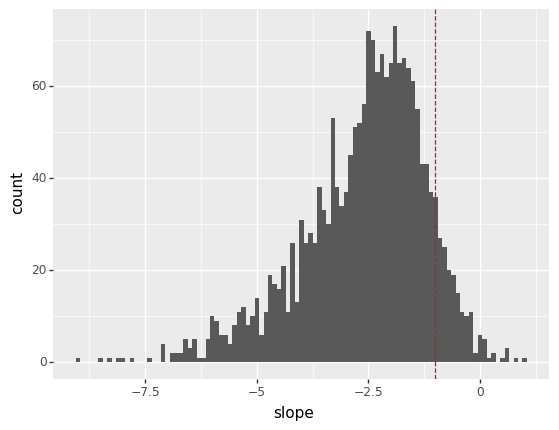

<ggplot: (-9223363287555364359)>


array([ 0.86432802, -0.06797336, -0.45594216, -1.07803498, -2.02076238,
       -2.71938747, -3.5204922 , -4.98505838, -7.2787996 ])

In [9]:

print(p9.ggplot(df.query("Article == '675315'")) +  #178729
 p9.aes(x='slope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed')
 )

np.quantile(df.query("Article == '178729'")['slope'],[0.99, 0.95, 0.90, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01])


Sampled article: 764955
norm
[('norm', 0.6289365551178491)]
{'norm': (-0.8122560336813871, 0.46370596105652917)}


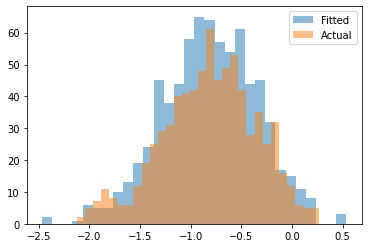

In [10]:
# determine best-fit distribution:
# https://www.hackdeploy.com/fitting-probability-distributions-with-python/
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = ['norm'] #['norm','lognorm','t', 'loggamma', 'gamma', 'dweibull']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            
            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))
        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p
        
        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the Fit method.')
            
    def Plot(self,y):
        x = self.Random(n=len(y))
        plt.hist(x, alpha=0.5, label='Fitted', bins=30)
        plt.hist(y, alpha=0.5, label='Actual', bins=30)
        plt.legend(loc='upper right')

from scipy.stats import norm
sample_article = df.query("(covid_flag == 'pre-covid')").Article.sample(1).iloc[0]
sample_dat = df.query("(Article == '"+sample_article+"') & (covid_flag == 'pre-covid')")

# trim the highest and lowest 1% to avoid fitting to problematic data.
if(1):
  sample_dat_quantiles = np.quantile(sample_dat.slope, [0.01, 0.99])
  trimmed_sample_dat = sample_dat[(sample_dat['slope'] > sample_dat_quantiles[0]) & (sample_dat['slope'] < sample_dat_quantiles[1])]
  r = trimmed_sample_dat.slope
else:
  r = sample_dat.slope

dst = Distribution()
dst.Fit(r)
dst.Plot(r)

print("Sampled article:",sample_article)
print(dst.DistributionName)
print(dst.dist_results)
print(dst.params)

In [11]:
np.mean(trimmed_sample_dat.slope< (-1))

0.3257372654155496

In [12]:
# prob_fit_dict = {}
# for sample_article in df.Article.unique():
#   sample_dat = df.query("(Article == '"+sample_article+"') & (covid_flag == 'pre-covid')")

#   try:
#   # trim the highest and lowest 1% to avoid fitting to problematic data.
#     if(1):
#       sample_dat_quantiles = np.quantile(sample_dat.slope, [0.01, 0.99])
#       trimmed_sample_dat = sample_dat[(sample_dat['slope'] > sample_dat_quantiles[0]) & (sample_dat['slope'] < sample_dat_quantiles[1])]
#       r = trimmed_sample_dat.slope
#     else:
#       r = sample_dat.slope
#     dst = Distribution()
#     dst.Fit(r)

#   #dst.Plot(r)
#     prob_fit_dict[sample_article] = {'Data':r, 'Dist':dst}
#   except:
#     pass

def dist_fit(df):
  prob_fit_dict = {}
  for sample_article in df.Article.unique():
    sample_dat = df.query("(Article == '"+sample_article+"') & (covid_flag == 'pre-covid')")

    try:
    # trim the highest and lowest 1% to avoid fitting to problematic data.
      if(1):
        sample_dat_quantiles = np.quantile(sample_dat.slope, [0.01, 0.99])
        trimmed_sample_dat = sample_dat[(sample_dat['slope'] > sample_dat_quantiles[0]) & (sample_dat['slope'] < sample_dat_quantiles[1])]
        r = trimmed_sample_dat.slope
      else:
        r = sample_dat.slope
      dst = Distribution()
      dst.Fit(r)

    #dst.Plot(r)
      prob_fit_dict[sample_article] = {'Data':r, 'Dist':dst}
    except:
      pass
  
  return prob_fit_dict

prob_fit_dict = dist_fit(df)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:291: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:291: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:291: Runtim

[-0.135, 0.813]

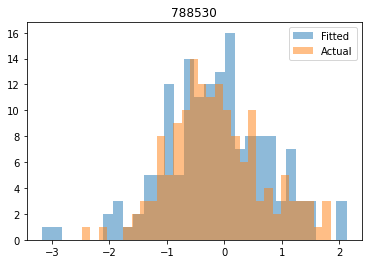

In [13]:
# view a random distribution fit
import random
sample_key = random.choice([x for x in prob_fit_dict.keys()])

prob_fit_dict[sample_key]['Dist'].Plot(prob_fit_dict[sample_key]['Data'])
plt.title(sample_key)
[round(x,3) for x in prob_fit_dict[sample_key]['Dist'].params['norm']]


## Clustering

[76336.64, 41172.71100301602, 15625.68561247458, 9021.132719820444, 6329.056424942448, 4553.326475055499, 3060.2862488964, 1676.6077616045586, 1118.1064757979868, 894.13010696637, 671.6263579191368, 536.7226121267277, 412.3093951945309, 354.1536989779323, 308.40389660334324, 272.0142055338357, 244.22196541673597, 221.14106644875403, 203.1170156917367, 183.0728458108456]


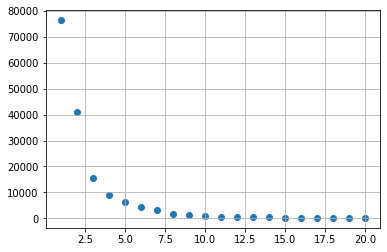

In [14]:
from sklearn.cluster import KMeans
import umap

def kmeans_diff_n(df,
                  n_clusters=[1],
                  max_iter=300,
                  tol=1e-04,
                  init='k-means++',
                  n_init=10,
                  algorithm='auto'):
    from sklearn.cluster import KMeans
    inertia_values = []
    for i in n_clusters:
        km = KMeans(n_clusters=i,
                    max_iter=max_iter,
                    tol=tol,
                    init=init,
                    n_init=n_init,
                    random_state=1,
                    algorithm=algorithm)
        km.fit_predict(df)
        inertia_values.append(km.inertia_)
    return inertia_values

df_wide = df.query("(covid_flag == 'pre-covid')").pivot(index="Site",
                   columns=["Article", "Sales_Unit"],
                   values="slope")

# drop column if all na's
df_wide = df_wide.dropna(axis=1, how='all')
# fill na with column medians
df_wide = df_wide.replace([np.inf, -np.inf], np.nan)
#df_wide = df_wide.apply(lambda x: x.fillna(x.median()))
df_wide = df_wide.apply(lambda x: x.fillna(0))
df_wide = df_wide.apply(lambda x: np.where(x < -10, -10, x))
df_wide = df_wide.apply(lambda x: np.where(x > 0, 0, x))

# find best number of clusters using elbow method:
embedding = umap.UMAP(n_neighbors=10, n_components=2).fit_transform(df_wide)

if (1):
    l_clusters = [
        x for x in np.array(range(1, min(21, df_wide.shape[0])))
        #if x == 1 or x % 3 == 0
    ]
    kmeans_var_explained = kmeans_diff_n(embedding, l_clusters)
    print(kmeans_var_explained)

plt.scatter(x=l_clusters, y=kmeans_var_explained)
plt.grid()


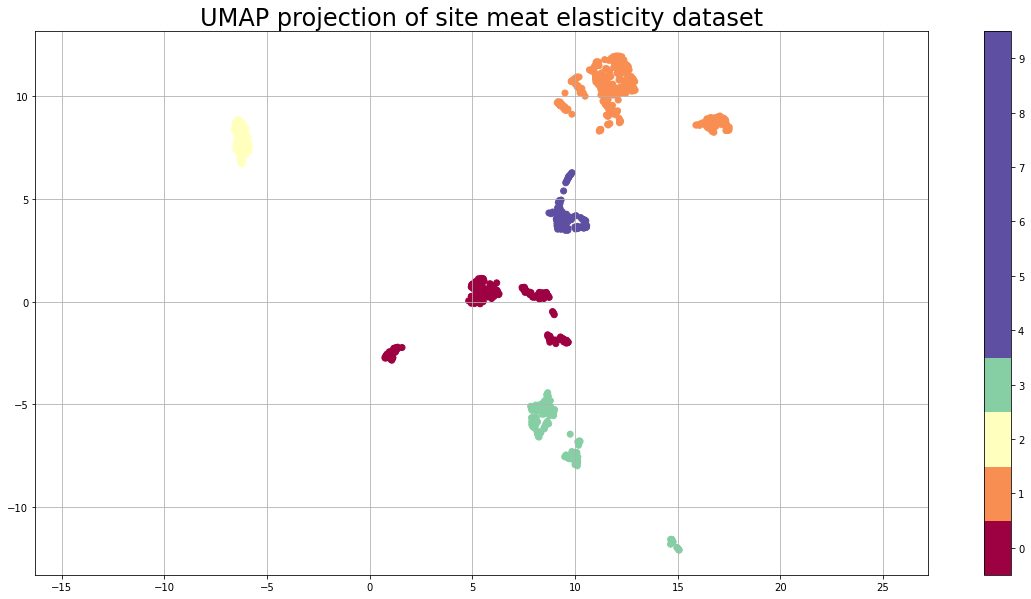

In [15]:

my_kmeans = KMeans(n_clusters=5, random_state=0).fit(embedding) #KMeans(n_clusters=5, random_state=0).fit(df_wide)

df_site_cluster_pair = pd.DataFrame({
    'site': list(df_wide.index),
    'cluster': list(my_kmeans.labels_)
})

plt.figure(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=my_kmeans.labels_, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of site meat elasticity dataset', fontsize=24);
plt.grid()


In [16]:
df_wide.head(3)

Article,100198,100292,100295,100297,100299,100360,100361,100373,100384,100386,100394,100398,100419,100427,100449,100450,100453,100457,100462,100525,100528,100532,100540,100590,100593,100596,100617,100749,100758,100765,100944,100983,101035,101036,101043,101063,101067,101076,101094,101103,...,953307,953642,954383,954392,954486,954488,954544,954547,954551,955488,958752,958757,958759,958761,958763,958808,964093,964833,964834,964835,964836,964837,964838,964839,964840,964841,964842,967114,969723,969724,970381,970382,971384,971388,971389,971390,972203,972206,972210,972212
Sales_Unit,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,...,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,EA,KG,EA,EA,KG,KG,KG,KG,KG,KG,KG,KG,EA,KG,KG,KG,KG,KG,KG,KG,KG,EA,EA,EA,EA
Site,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1004,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.395797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.012240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.519422,-1.420790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.372953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030,0.0,0.0,-3.282609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090369,0.0,0.0,0.0,-4.778401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.395823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.44019,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.445274,-0.977806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.985171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Misc

In [17]:
print(df.shape)
df.head(3)

(661122, 22)


,SalesOrg,Site,Article,Article_Description,Category_Description,SubCategory_Description,Sales_Unit,covid_flag,mean_x,mean_y,corr_xy,sd_x,sd_y,cnt_overs,cnt_unders,perc_unders,Sales_ExclTax,Sales_Qty_SUoM,ASP,slope,y_intercept,elasticity_score
0,1005,7203,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,0.001580,0.032665,-0.308951,0.149712,0.876094,34,34,0.151111,8926.28,587.551,15.192349,-1.807933,0.035521,7211.831726
1,1005,7004,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,0.006455,-0.055863,-0.385575,0.180963,0.801315,27,25,0.215517,4802.82,321.343,14.946086,-1.707344,-0.044843,3397.245890
2,1005,5659,100198,Gravy Beef kg 5,MEAT,BEEF,KG,covid (Other),-0.001324,-0.027469,-0.182007,0.113350,0.865269,21,21,0.123529,15979.05,924.584,17.282421,-1.389369,-0.029309,6221.754156


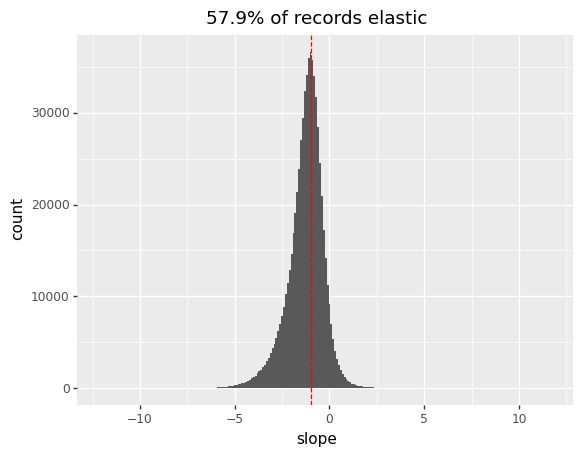

<ggplot: (8749288308193)>

In [18]:
# look at distribution of model slopes. Change in qty sold given change in price.
(p9.ggplot(df) + 
 p9.aes(x='slope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.labs(title=str(round(np.mean(df.slope < -1)*100,1))+"% of records elastic")
 )


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


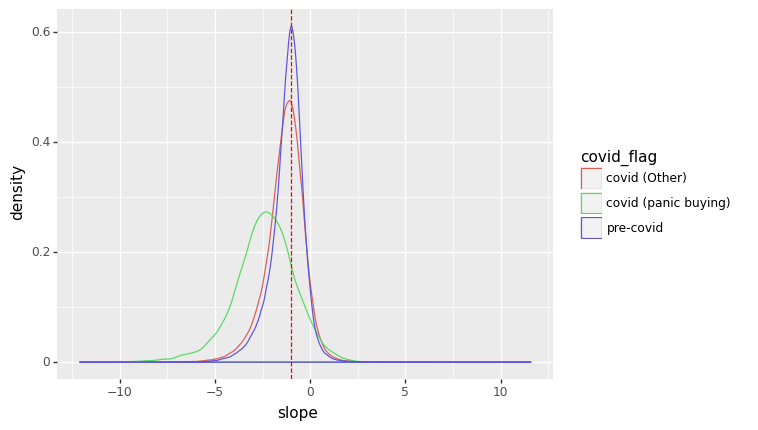

<ggplot: (-9223363287555711828)>

In [19]:
# look at distribution of model slopes by covid period. Overall.
(p9.ggplot(df) + 
 p9.aes(x='slope', color='covid_flag') + 
 p9.geom_density() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed')
 )


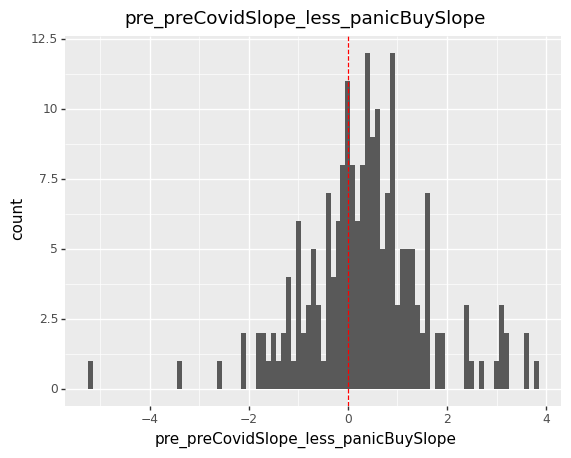

<ggplot: (-9223363287550542788)>


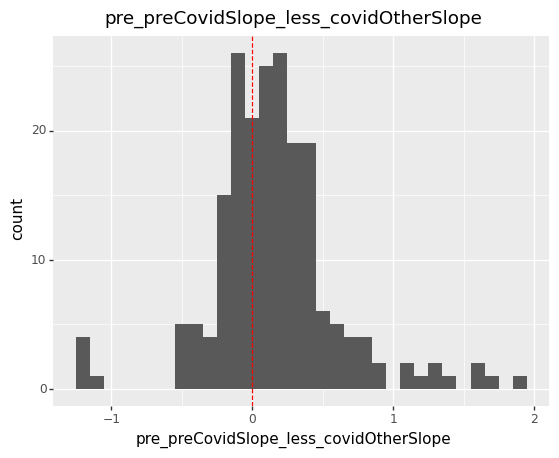

<ggplot: (-9223363287566736275)>


In [20]:
# look at distribution of model slopes by covid period. Per article
covid_compare_article = df.pivot_table(index=['Article','Article_Description',	'Category_Description',	'SubCategory_Description',	'Sales_Unit'], columns='covid_flag', values='slope').dropna().reset_index()
covid_compare_article['pre_preCovidSlope_less_panicBuySlope'] = covid_compare_article['pre-covid']-covid_compare_article['covid (panic buying)']
covid_compare_article['pre_preCovidSlope_less_covidOtherSlope'] = covid_compare_article['pre-covid']-covid_compare_article['covid (Other)']

print(p9.ggplot(covid_compare_article) + 
 p9.aes(x='pre_preCovidSlope_less_panicBuySlope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= 0, color='red', linetype='dashed') +
 p9.labs(title="pre_preCovidSlope_less_panicBuySlope")
 )

print(p9.ggplot(covid_compare_article) + 
 p9.aes(x='pre_preCovidSlope_less_covidOtherSlope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= 0, color='red', linetype='dashed') +
 p9.labs(title="pre_preCovidSlope_less_covidOtherSlope")
 )

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.6/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


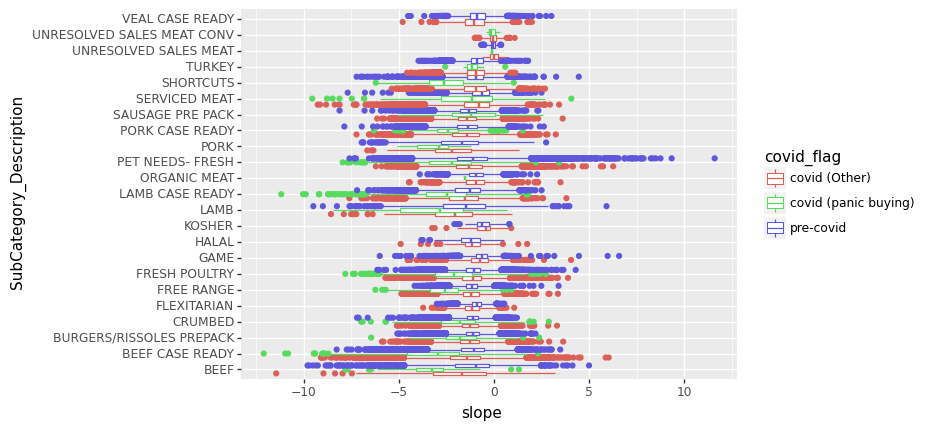

<ggplot: (-9223363287553321528)>

In [21]:
# look at distribution of model slopes. Change in qty sold given change in price.
(p9.ggplot(df) + 
 p9.aes(x='SubCategory_Description', y='slope', color='covid_flag') + 
 #p9.geom_histogram(binwidth=0.1) +
 p9.geom_boxplot() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.coord_flip() 
 )


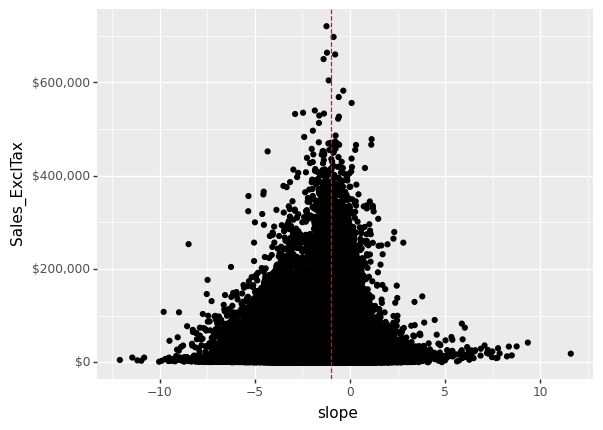

<ggplot: (-9223363287566618273)>

In [22]:
# look at slopes against sales $s. The idea being that we should focus more attention of more popular products.
(p9.ggplot(df) + 
 p9.aes(x='slope', y='Sales_ExclTax') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.scale_y_continuous(labels=currency_format(big_mark=',', digits=0))
 )


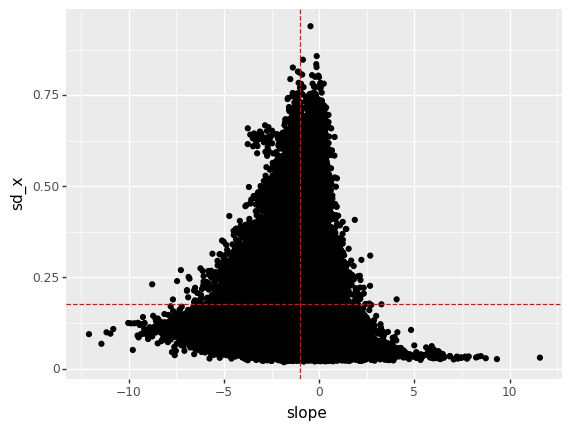

<ggplot: (8749285248681)>

In [23]:
# Check if we are often moving prices on inelastic articles.
# look at price variations relative to slopes.

(p9.ggplot(df) + 
 p9.aes(x='slope', y='sd_x') +#, color='Sales_ExclTax') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.geom_hline(yintercept= np.median(df.sd_x), color='red', linetype='dashed') #+
 #p9.scale_color_gradient2(low='White', mid='Gray', high='Red', midpoint=np.median(df.Sales_ExclTax))
 )


In [24]:
df.query("slope > -1").sort_values('Sales_ExclTax', ascending=False)

,SalesOrg,Site,Article,Article_Description,Category_Description,SubCategory_Description,Sales_Unit,covid_flag,mean_x,mean_y,corr_xy,sd_x,sd_y,cnt_overs,cnt_unders,perc_unders,Sales_ExclTax,Sales_Qty_SUoM,ASP,slope,y_intercept,elasticity_score
213534,1005,1800,577860,Heart Smart Extra Lean Beef Mince 500g,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.000833,-0.004244,-0.169736,0.091685,0.467553,41,33,0.044959,697730.550,92867.000,7.513224,-0.865581,-0.003523,-93787.989874
221163,1005,4324,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.003299,-0.003995,-0.230797,0.103610,0.351570,48,36,0.054463,660218.060,83714.000,7.886591,-0.783142,-0.001412,-143173.344701
2482,1005,5636,100540,Lamb Forequarter Chops Kg 5,MEAT,LAMB,KG,pre-covid,0.001594,-0.001004,-0.047005,0.091732,0.694500,88,85,0.144804,582446.100,42066.800,13.845743,-0.355875,-0.000437,-375168.013606
15166,1005,5636,114010,Mince Beef Regular Lrg Kg 3,MEAT,BEEF,KG,pre-covid,0.002495,-0.014304,-0.043033,0.034240,0.473591,28,11,0.018212,568771.160,72255.865,7.871626,-0.595212,-0.012819,-230231.749396
221644,1005,2234,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.004370,-0.001756,0.006418,0.038169,0.486415,22,9,0.014173,556119.250,67192.000,8.276569,0.081787,-0.002114,-601602.568824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102124,1005,2824,26529,Fussy Cat Pots Tartare Kangaroo 70g,MEAT CONVENIENCE,PET NEEDS- FRESH,EA,pre-covid,-0.003282,-0.013946,-0.433072,0.427233,0.866356,8,7,0.437500,43.860,27.000,1.624444,-0.878198,-0.016829,-5.342245
536344,1005,2509,785535,4Legs Gmt Chicken W/Cheese Pars 200g,MEAT CONVENIENCE,PET NEEDS- FRESH,EA,covid (Other),-0.002321,-0.115525,0.295968,0.150348,0.812848,7,7,0.388889,43.841,29.000,1.511759,1.600137,-0.111810,-113.992589
103572,1005,3319,26588,Fussy Cat Pots Liver Top Chckn 70g,MEAT CONVENIENCE,PET NEEDS- FRESH,EA,pre-covid,0.005682,-0.127388,-0.429638,0.369057,0.688779,7,8,0.421053,43.448,25.000,1.737920,-0.801842,-0.122832,-8.609582
102172,1005,1302,26529,Fussy Cat Pots Tartare Kangaroo 70g,MEAT CONVENIENCE,PET NEEDS- FRESH,EA,pre-covid,0.018679,-0.358970,-0.133258,0.484007,0.660107,8,7,0.388889,40.749,25.000,1.629960,-0.181743,-0.355576,-33.343169


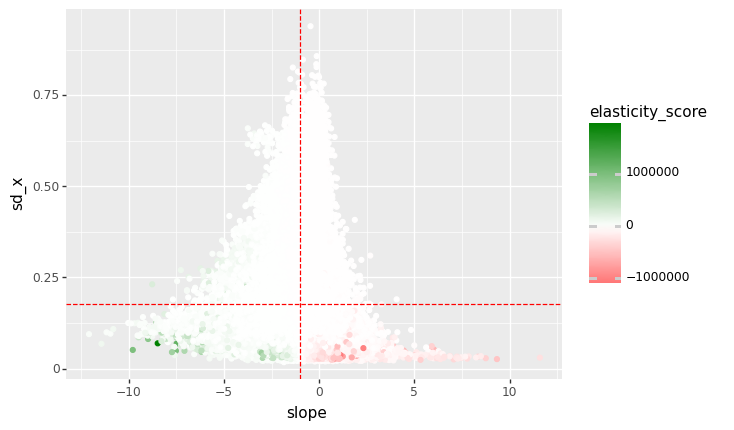

<ggplot: (-9223363287569958319)>


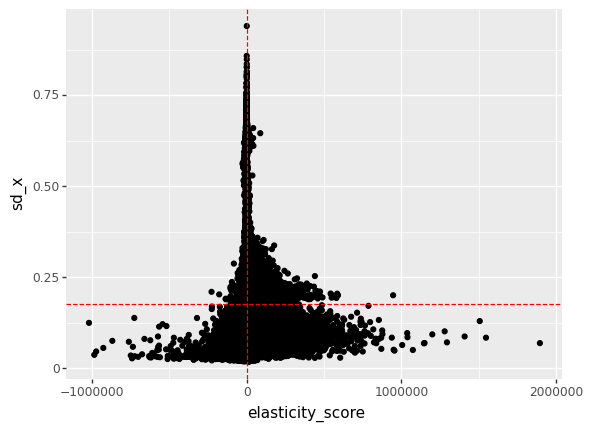

<ggplot: (-9223363287573617583)>


In [25]:
print(p9.ggplot(df) + 
 p9.aes(x='slope', y='sd_x', color='elasticity_score') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.geom_hline(yintercept= np.median(df.sd_x), color='red', linetype='dashed') +
 p9.scale_color_gradient2(low='Red', mid='White', high='Green', midpoint=np.median(df.elasticity_score))
 )

print(p9.ggplot(df) + 
 p9.aes(x='elasticity_score', y='sd_x') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= np.median(df.elasticity_score), color='red', linetype='dashed') +
 p9.geom_hline(yintercept= np.median(df.sd_x), color='red', linetype='dashed')
 )
